In [1]:
import os 
import pathlib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot as skplt
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix

# Loading the dataset

In [2]:
data_dir = pathlib.Path('cell_images')
slide_labels = ['Parasitized', ['Uninfected']]

CLASS_NAMES = slide_labels 
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(data_dir.glob('*/*.png')))

def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    return tf.where(parts[-2] == CLASS_NAMES)[0][0]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    return img  

def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    features = {'image': img, 'label': label}
    return features

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
print("Total number of images", len(ds))

Total number of images 27558


# Splitting the dataset

In [3]:
train_size = int(0.90 * num_examples)
val_size = int(0.09* num_examples)
test_size = int(0.01 * num_examples)

full_dataset = ds.shuffle(reshuffle_each_iteration=False, buffer_size=len(ds))
train_dataset = full_dataset.take(train_size)
test_val_dataset = full_dataset.skip(train_size)
val_dataset = test_val_dataset.take(val_size)
test_dataset = test_val_dataset.skip(val_size)

In [4]:
print("Number of examples on training set is ", len(train_dataset))

Number of examples on training set is  24802


It is good practice to take a random example of a dataset and check that it loads as expected

tf.Tensor(1, shape=(), dtype=int64)


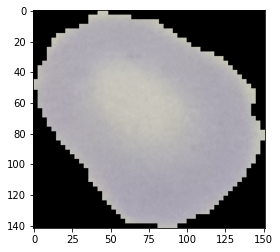

tf.Tensor(1, shape=(), dtype=int64)


In [5]:
for features in val_dataset.take(1):
    image = features['image']
    label = features['label']
    print(label)
plt.imshow(image)
plt.show()
print(label)

# Model development

Loading BiT-M R50x1 model

In [6]:
module = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=False) #Freezes the layers so that the weights are maintained

Below, we add a new output layer to the feature extractor, with number of neurons equal to the number of classes

In [7]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros') #New output layer with weights initialised to 0
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

Defining model hyperparameters and augmenting the training and validation datasets

In [8]:
# Preprocessing helper functions
# Create data pipelines for training and validating:

BATCH_SIZE = 512
SCHEDULE_LENGTH = 500
RESIZE_TO = 128
STEPS_PER_EPOCH = 48 #len(training_Set)//batch_size

def cast_to_tuple(features):
    return (features['image'], features['label'])

def preprocess_train(features):
  # Apply horirzontal and vertical flips
  # Resize images and normalise them
    features['image'] = tf.image.random_flip_left_right(features['image'])
    features['image'] = tf.image.random_flip_up_down(features['image'])
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

def preprocess_validate(features):
    # Apply horirzontal and vertical flips
    # Resize images and normalise them
    features['image'] = tf.image.random_flip_left_right(features['image'])
    features['image'] = tf.image.random_flip_up_down(features['image'])
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features


pipeline_train = (train_dataset
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / num_examples * STEPS_PER_EPOCH))  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_validate = (val_dataset.map(preprocess_validate, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,restore_best_weights=True) #Early stopping with val loss being monitored
model_checkpoint = ModelCheckpoint(filepath='best_model', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)

lr = 0.003 #Learning rate
SCHEDULE_BOUNDARIES = [720,1440,2160] #Steps at which to decay the learning rate

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.01, lr*0.001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

log_dir = "logs/fit/22-04-2021-BiT-HyperRule" #log directory for Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
# Fitting the model for 50 epochs
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(50), 
    validation_data=pipeline_validate,
    callbacks=[tensorboard_callback,es,model_checkpoint]
)

Epoch 1/50
48/48 [==============================] - 91s 1s/step - loss: 0.6368 - accuracy: 0.8710 - val_loss: 0.2003 - val_accuracy: 0.9444

Epoch 00001: val_loss improved from inf to 0.20026, saving model to best_model
Epoch 2/50
48/48 [==============================] - 51s 1s/step - loss: 0.2236 - accuracy: 0.9404 - val_loss: 0.1839 - val_accuracy: 0.9536

Epoch 00002: val_loss improved from 0.20026 to 0.18391, saving model to best_model
Epoch 3/50
48/48 [==============================] - 52s 1s/step - loss: 0.2145 - accuracy: 0.9447 - val_loss: 0.1594 - val_accuracy: 0.9484

Epoch 00003: val_loss improved from 0.18391 to 0.15940, saving model to best_model
Epoch 4/50
48/48 [==============================] - 51s 1s/step - loss: 0.1891 - accuracy: 0.9436 - val_loss: 0.3329 - val_accuracy: 0.9056

Epoch 00004: val_loss did not improve from 0.15940
Epoch 5/50
48/48 [==============================] - 51s 1s/step - loss: 0.1695 - accuracy: 0.9500 - val_loss: 0.1342 - val_accuracy: 0.9552


In [29]:
model.load_weights('best_model') #loading in the best weights

# Pre-train checks

Before we fully train the model for the desired number of epochs, we should always perform the sum of probabilities test and invariance checks. This will help us save valuable time and resources and inform us if the model is valid before we fully train it

### Sum of probabilities of the output

In a classification task, the sum of output of all the neurons in the final layer should add upto 1. I'd usually train the model for 1 epoch, and test this.
<br>Here, we take the first 5 images of the test set and check whether this is true
<br>Note that this is to be done before fully training the model, by setting the epoch to 1 or a very low number such that we get quick validation. 

### Invariance checks

We also need to make sure that the output of the model doesn't change when the image is rotated/ flipped or any other operation which does not affect the main features of the image is performed. 

Sum of model output is  1.0
Image is predicted to be class  0
Rotated image is predicted to be class  0


<Figure size 360x360 with 0 Axes>

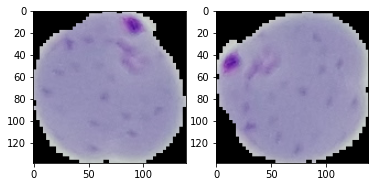

In [30]:
plt.figure(figsize=(5,5))
f, axarr = plt.subplots(1,2) 
for features in test_dataset.take(1):
    image = features['image']
    axarr[0].imshow(image)
    image = tf.image.resize(image, [128, 128])
    image= tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis = 0)
    label = features['label']
    
    test_logits = model(image) # Run model on image
    sum_proba = (np.sum(tf.nn.softmax(test_logits).numpy()[0])) #Checking if the sum of probabilities is valid (should be 1)
    print("Sum of model output is ", sum_proba)
    index_max_proba = np.argmax(tf.nn.softmax(test_logits))
    print("Image is predicted to be class ", index_max_proba)
    
    #For rotated image
    image_rotated = features['image']
    image_rotated = tf.image.rot90(image_rotated, k=1, name=None)
    axarr[1].imshow(image_rotated)
    image_rotated = tf.image.resize(image_rotated, [128, 128])
    image_rotated = tf.cast(image_rotated, tf.float32) / 255.0
    image_rotated = tf.expand_dims(image_rotated, axis = 0)
    
    rotated_img_logits = model(image_rotated) #Run model on rotated image    
    rotated_max_proba = np.argmax(tf.nn.softmax(rotated_img_logits))
    print("Rotated image is predicted to be class ", rotated_max_proba)

As you can see, we passed both our tests! The model output sums to 1, and also the prediction on the image remains the same even if the image is rotated.

# Testing on the full test set

In [31]:
print("Total length of test dataset is ", len(test_dataset))

prediction_list = []
y_true = []
y_probabilities = [] #List of prediction probabilities, useful for plotting ROC-AUC later on
correct = []
incorrect = []

for features in test_dataset.take(276):
    image = features['image']
    image = tf.image.resize(image, [128, 128])
    image= tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis = 0)
    label = features['label']

    # Run model on image
    logits = model(image)
    y_probabilities.append(tf.nn.softmax(logits).numpy()[0])
    index_max_proba = np.argmax(tf.nn.softmax(logits))
    label_value = tf.keras.backend.get_value(label)
    y_true.append(label_value)
    prediction_list.append(index_max_proba)

    if label_value == index_max_proba:
        correct.append(1)
    else:
        incorrect.append(1)
        
test_set_acc = len(correct)/(len(correct)+len(incorrect))
print("Accuracy on test set is ",test_set_acc)

Total length of test dataset is  276
Accuracy on test set is  0.9746376811594203


# Confusion matrix

The confusion matrix allows us to evluate the model in the form of NxN matrix, where N is the number of classes. It gives us a good idea of the models performance and the errors (false positives and false negatives) it is making

[[145   2]
 [  5 124]]


/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass labels=['Parasitised', 'Uninfected'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


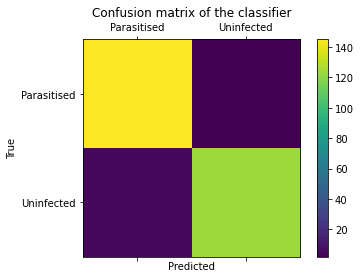

In [32]:
# Converting the true labels and predicted labels to text classes for the confusion matrix. 
labelled_y_true = []
labelled_y_pred = []

for l in y_true:
    if l == 1:
        labelled_y_true.append('Uninfected')
    elif l == 0:
        labelled_y_true.append('Parasitised')
for k in prediction_list:
    if k == 1:
        labelled_y_pred.append('Uninfected')
    elif k == 0:
        labelled_y_pred.append('Parasitised')
        
# Plotting the confusion matrix
labels = ['Parasitised', 'Uninfected']
cm = confusion_matrix(labelled_y_true,labelled_y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

As you can see, we misclassified 7 examples, with 5 of them being uninfected images classed as infected. This is good, as in a production environment, the model will be optimised to lower the number of infected images being predicted as uninfected, as this will result in more serious issues than the opposite case

# ROC-AUC curve

The area under the Receivers operating Characteristic curve is a really important measure of the models performance. The extract below is from a simple explanation of ROC-AUC curve [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
<br>
"AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease"

/home/ec2-user/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


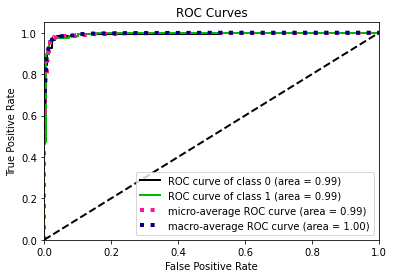

In [33]:
skplt.metrics.plot_roc_curve(y_true, y_probabilities)
plt.show()

The model trained has an AUC of 0.99, which means it is highly capable of distinguishing between classes.

----